# Using DESC Interactively

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

In [2]:
%matplotlib inline
import numpy as np
from desc.equilibrium import Equilibrium
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import PowerSeriesProfile
from desc.plotting import plot_1d, plot_section, plot_surfaces

DESC version 0.10.1+161.geb6ad4b2,using JAX backend, jax version=0.4.13, jaxlib version=0.4.13, dtype=float64
Using device: CPU, with 14.82 GB available memory


**Jupyter Documentation Tip: pressing `shift+tab` when the cursor is inside a function will show the documentation! Take advantage of DESC's documentation!**

See the [DESC documentation page](https://desc-docs.readthedocs.io/en/latest/theory_general.html) for more information on the functionalities shown here

## Initializing an Equilibrium

Let's start with a simple example of a circular tokamak. We'll start by defining the boundary, which is represented by a double Fourier series for R and Z in terms of a poloidal angle $\theta$ and the geometric toroidal angle $\zeta$. We specify the mode numbers for R and Z as 2d arrays of `[m,n]` pairs, and the coefficients as a 1d array.

In DESC the double Fourier series for R and Z are defined in a slightly different manner than VMEC:

$$
\begin{align}
    R^b(\theta,\zeta) &= \sum^M \sum^N R^b_{mn} \mathcal{G}^{m}_{n}(\theta,\zeta)\\
    Z^b(\theta,\zeta) &= \sum^M \sum^N Z^b_{mn} \mathcal{G}^{m}_{n}(\theta,\zeta)
\end{align}
$$

where

$$
   \mathcal{G}^{m}_{n}(\theta,\zeta) = \begin{cases}
   \cos(|m|\theta)\cos(|n|N_{FP}\zeta) &\text{for }m\ge0, n\ge0 \\
   \cos(|m|\theta)\sin(|n|N_{FP}\zeta) &\text{for }m\ge0, n<0 \\
   \sin(|m|\theta)\cos(|n|N_{FP}\zeta) &\text{for }m<0, n\ge0 \\
   \sin(|m|\theta)\sin(|n|N_{FP}\zeta) &\text{for }m<0, n<0.
   \end{cases}
$$

**Note**: in DESC, radial modes are indexed by `l`, poloidal modes by `m`, and toroidal modes by `n`

In this case we'll use a major radius of 10 and a minor radius of 1:

$$
\begin{align}
    R^b(\theta,\zeta) &= 10 + cos(\theta)\\
    Z^b(\theta,\zeta) &= -sin(\theta)
\end{align}
$$

which we define in DESC with the following surface:

In [3]:
surface = FourierRZToroidalSurface(
    R_lmn=[10, 1],
    modes_R=[[0, 0], [1, 0]],  # modes given as [m,n] for each coefficient
    Z_lmn=[0, -1],
    modes_Z=[[0, 0], [-1, 0]],
)

Next, we need to define the profiles. We'll take a vacuum case to start (pressure=0), and a simple quadratic $\iota$ profile. The profiles are given in terms a simple monic power series in powers of $\rho^l$:

$$
\begin{align}
    p(\rho)&=0\\
    \iota(\rho) &= 1 + 1.5\rho^2
\end{align}
$$

We create these in DESC as follows. We will give the pressure profile both a constant and a quadratic term which we set to zero for now, as later we will then add pressure to this equilbrium.

In [4]:
# this is a constant pressure of 0
pressure = PowerSeriesProfile(params=[0, 0], modes=[0, 2])
iota = PowerSeriesProfile(params=[1, 1.5], modes=[0, 2])  # iota = 1 + 1.5 r^2

Finally, we create an `Equilibrium` object by giving it the surface and profiles, as well as specifying what resolution we want to use and a few other parameters:

In [5]:
eq = Equilibrium(
    surface=surface,
    pressure=pressure,
    iota=iota,
    Psi=1.0,  # flux (in Webers) within the last closed flux surface
    NFP=1,  # number of field periods
    L=7,  # radial spectral resolution
    M=7,  # poloidal spectral resolution
    N=0,  # toroidal spectral resolution (axisymmetric case, so we don't need any toroidal modes)
    L_grid=12,  # real space radial resolution, slightly oversampled
    M_grid=12,  # real space poloidal resolution, slightly oversampled
    N_grid=0,  # real space toroidal resolution (axisymmetric, so we don't need any grid points toroidally)
    sym=True,  # explicitly enforce stellarator symmetry
)

This will automatically create the needed spectral bases and generates an initial guess for the flux surfaces by scaling the boundary surface, which we can plot below:

## Plotting

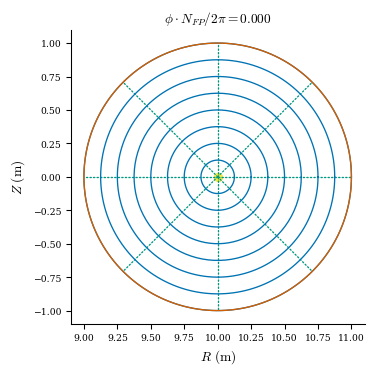

In [6]:
# plot_surfaces generates poincare plots of the flux surfaces
plot_surfaces(eq);

We can also look at the force balance error:

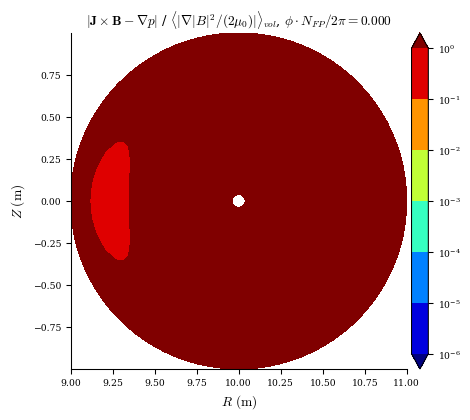

In [7]:
# plot_section plots various quantities on a toroidal cross-section
# the second argument is a string telling it what to plot, in this case the force error density
# we could also look at B_z, (the toroidal magnetic field), or sqrt(g) (the coordinate jacobian) etc.,
# here we also tell it to normalize the force error (relative to the magnetic pressure gradient or thermal pressure if present)
plot_section(eq, "|F|", norm_F=True, log=True);

We see that this is very far from an equilibrium. Let's try to fix that.

## Solving the Equilibrium

First, we need to give the equilibrium an objective that should be minimized, in this case we'll choose to minimize the force balance error. 

We also need to select an optimizer. Many options from `scipy.optimize` are available, as well as a few custom solvers that may be more efficient in some cases

In DESC this is done by creating an `Optimizer` object, which handles the logic of passing the derivative information from the equilibrium to the solving routines.

In [8]:
from desc.optimize import Optimizer

# create an Optimizer object using the lsq-exact optimizer
optimizer = Optimizer("lsq-exact")

To select an objective, we must create an `ObjectiveFunction` object with the desired objective (such as force balance error) and we must also define a tuple of the desired constraints (such as keeping the LCFS, pressure, iota and psi fixed, as in the case of a fixed boundary equilibrium solve)

In [9]:
from desc.objectives import (
    get_fixed_boundary_constraints,
    ObjectiveFunction,
    FixBoundaryR,
    FixBoundaryZ,
    FixPressure,
    FixIota,
    FixPsi,
    ForceBalance,
)

constraints = (
    FixBoundaryR(eq=eq),  # enforce fixed  LCFS for R
    FixBoundaryZ(eq=eq),  # enforce fixed  LCFS for R
    FixPressure(eq=eq),  # enforce that the pressure profile stay fixed
    FixIota(eq=eq),  # enforce that the rotational transform profile stay fixed
    FixPsi(eq=eq),  # enforce that the enclosed toroidal stay fixed
)
# choose the objectives to be ForceBalance(), which is a wrapper function for RadialForceBalance() and HelicalForceBalance()
objectives = ForceBalance(eq=eq)
# the ObjectiveFunction object which we can pass to the eq.solve method
obj = ObjectiveFunction(objectives=objectives)

a utility function, `get_fixed_boundary_constraints()` exists that will create the typical constraints for a fixed boundary equilibrium

In [10]:
constraints2 = get_fixed_boundary_constraints(eq)
print("Same constraints for each")
for c1, c2 in zip(constraints, constraints2):
    print("type of ", c1, "=", "type of ", c2, ":\n", type(c1) == type(c2))

Same constraints for each
type of  <desc.objectives.linear_objectives.FixBoundaryR object at 0x7fe2c4b06dd0> = type of  <desc.objectives.linear_objectives.FixBoundaryR object at 0x7fe05d5adf90> :
 True
type of  <desc.objectives.linear_objectives.FixBoundaryZ object at 0x7fe05d5adcc0> = type of  <desc.objectives.linear_objectives.FixBoundaryZ object at 0x7fe05d5acc10> :
 True
type of  <desc.objectives.linear_objectives.FixPressure object at 0x7fe05d5af010> = type of  <desc.objectives.linear_objectives.FixPsi object at 0x7fe05d5ac700> :
 False
type of  <desc.objectives.linear_objectives.FixIota object at 0x7fe05d5afa60> = type of  <desc.objectives.linear_objectives.FixPressure object at 0x7fe05d5ae7a0> :
 False
type of  <desc.objectives.linear_objectives.FixPsi object at 0x7fe05d5adb40> = type of  <desc.objectives.linear_objectives.FixIota object at 0x7fe05d5aeef0> :
 False



Next, we simply call `eq.solve()` to minimize the force balance error. 

Here we can also pass in arguments such as the maximum number of iterations or stopping tolerances. We also must pass in our constraints for the equilibrium solve. 

Under the hood, the objective function and its derivative are JIT compiled for the specific parameters we defined above before being passed to the optimizer.

In [11]:
eq.solve(
    verbose=3,
    ftol=1e-8,
    maxiter=50,
    constraints=constraints,
    optimizer=optimizer,
    objective=obj,
);

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 2.90 sec
Timer: Objective build = 4.40 sec
Timer: Linear constraint projection build = 3.84 sec
Compiling objective function and derivatives: ['force']
Timer: Objective compilation time = 1.14 sec
Timer: Jacobian compilation time = 2.34 sec
Timer: Total compilation time = 3.49 sec
Number of parameters: 37
Number of objectives: 98
Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          3.412e-03                                    1.041e+00   
       1              3          2.884e-05      3.383e-03      1.694e-01      1.286e-01   
       2              4          6.936e-07      2.815e-05      4.484e-02      1.453e-02   
       3              5          2.661e-08      6.670e-07      7.599e-03      2.657e-03   
       4              6          1.493e-09      2.511e-08      3.859e-03      6.483e

We can then look at the flux surfaces and force error again:

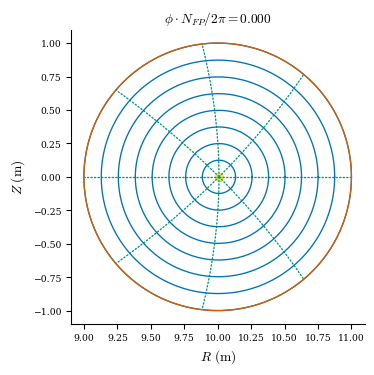

In [12]:
plot_surfaces(eq);

## Perturbing the equilibrium
Now we have a solved zero beta equilibrium. If we want to see what this equilibrium solution looks like with finite pressure, we could redo the above steps, but with a different pressure profile. But, in DESC one can perturb an existing equilibrium in order to find nearby solution. Let's do this to find a finite pressure solution of this equilibrium.

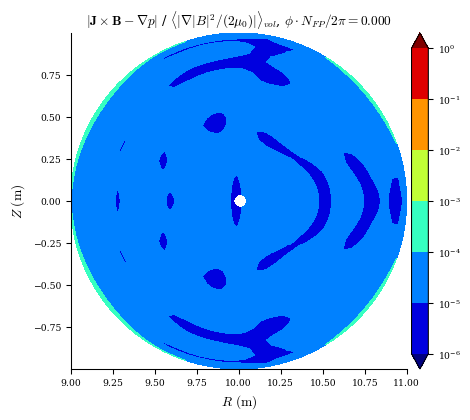

In [13]:
plot_section(eq, "|F|", norm_F=True, log=True);

## Perturbations

Next, we can ask "what would this equilibrium look like if we add pressure to it?"

We can answer this by applying a pressure perturbation to the current equilibrium. 

First, let's plot the pressure to make sure it's really zero:

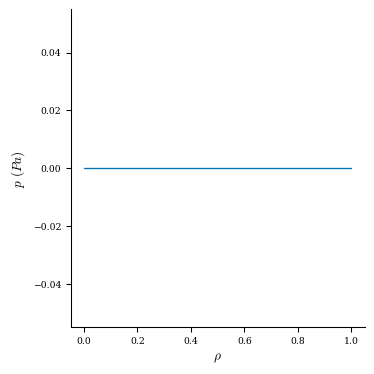

In [14]:
plot_1d(eq, "p");  # original eq with zero pressure

Next, let's decide on how much we want to increase the pressure.

We'll give it a quadratic profile, peaked at 1000 Pascals in the core and dropping to 0 at the edge.

The perturbation is given in the same form the original profiles were (a power series in $\rho$)

In [15]:
delta_p = np.zeros_like(eq.p_l)
delta_p[0] = 1000.0
delta_p[1] = -1000.0

In [16]:
eq1 = eq.perturb(
    deltas={"p_l": delta_p}, order=2, objective=obj, constraints=constraints
)

Perturbing p_l
Factorizing linear constraints
Computing df
Factoring df
Computing d^2f
||dx||/||x|| =  3.944e-03


Note that this gives us back a new equilibrium, so that the original is saved for future study.

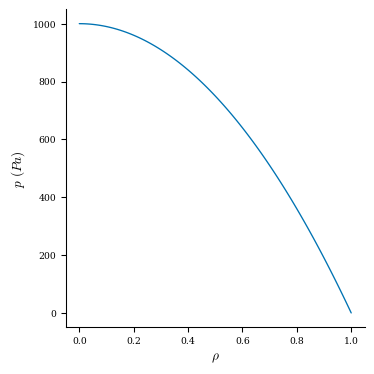

In [17]:
plot_1d(eq1, "p");

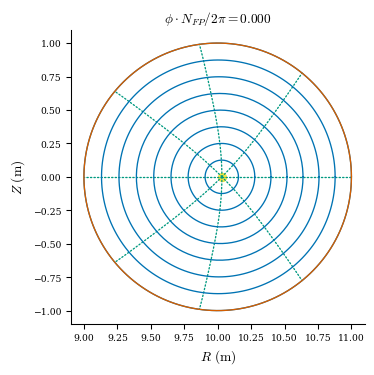

In [18]:
plot_surfaces(eq1);

Note the changes in the flux surface, and the slight outward movement of the axis

During the perturbation, the force error increased slightly, but still remains less than 10%

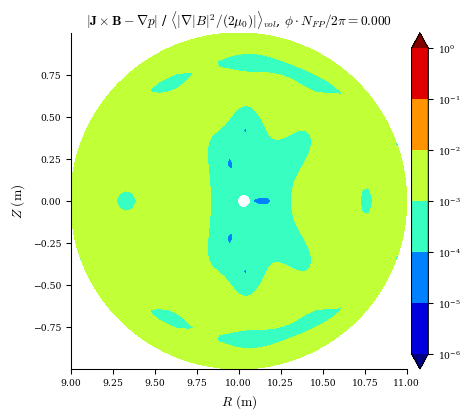

In [19]:
plot_section(eq1, "|F|", norm_F=True, log=True);

We can do a few Newton iterations to converge the solution again, this should go much faster than the initial solution

In [20]:
# the default ObjectiveFunction is force balance, and the default optimizer is 'lsq-exact'
eq1.solve(
    verbose=2, ftol=1e-4, optimizer=optimizer, objective=obj, constraints=constraints
);

Timer: Linear constraint projection build = 381 ms
Compiling objective function and derivatives: ['force']
Timer: Objective compilation time = 2.29 ms
Timer: Jacobian compilation time = 4.11 ms
Timer: Total compilation time = 10.2 ms
Number of parameters: 37
Number of objectives: 98
Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          1.131e-08                                    2.080e-03   
       1              2          1.513e-10      1.116e-08      2.171e-03      1.932e-04   
       2              3          9.243e-11      5.891e-11      9.305e-04      3.864e-05   
       3              4          9.057e-11      1.862e-12      8.056e-05      2.187e-07   
       4              5          9.056e-11      9.134e-15      7.896e-05      2.676e-07   
       5              6          9.056e-11      1.001e-15      1.402e-05      9.188e-09   
`gtol` condition satisfied.
     

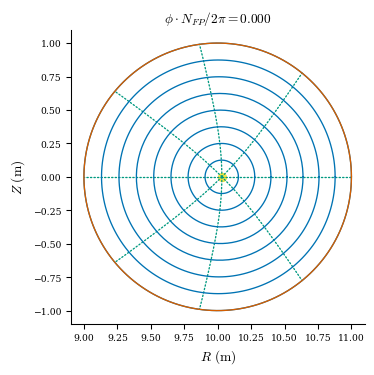

In [21]:
plot_surfaces(eq1);

Note that the flux surfaces and axis location only change by a tiny amount during the Newton iterations - the perturbation captured them accurately

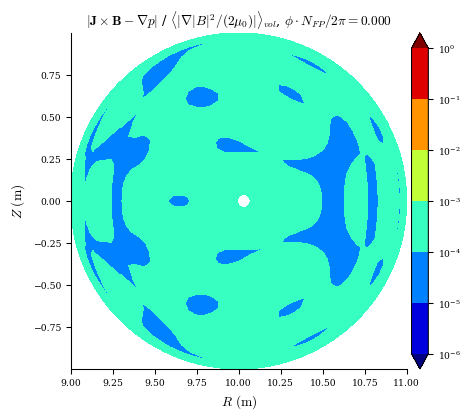

In [22]:
plot_section(eq1, "|F|", norm_F=True, log=True);

Next, we might want to try twisting our tokamak into a stellarator. We can accomplish this in a similar way, by applying a 3d boundary perturbation.

However, first we need to give our tokamak some non-axisymmetric modes in its spectral basis:

In [23]:
eq1.change_resolution(N=2, N_grid=4)

In [24]:
# remake the constraints and objective, since we have changed the resolution of our equilibrium
constraints = (
    FixBoundaryR(eq=eq),  # enforce fixed  LCFS for R
    FixBoundaryZ(eq=eq),  # enforce fixed  LCFS for R
    FixPressure(eq=eq),  # enforce that the pressure profile stay fixed
    FixIota(eq=eq),  # enforce that the rotational transform profile stay fixed
    FixPsi(eq=eq),  # enforce that the enclosed toroidal stay fixed
)
# choose the objectives to be ForceBalance(), which is a wrapper function for RadialForceBalance() and HelicalForceBalance()
objectives = ForceBalance(eq=eq)
# the final ObjectiveFunction object which we can pass to the eq.solve method
obj = ObjectiveFunction(objectives=objectives)

Now we can apply a 3d perturbation by perturbing the coefficients of the double Fourier series that defines the plasma boundary:

In [25]:
delta_R = np.zeros_like(eq1.Rb_lmn)
delta_Z = np.zeros_like(eq1.Zb_lmn)
delta_R[eq1.surface.R_basis.get_idx(M=1, N=1)] = -0.4
delta_Z[eq1.surface.Z_basis.get_idx(M=1, N=-1)] = -0.4

eq2 = eq1.perturb(deltas={"Rb_lmn": delta_R, "Zb_lmn": delta_Z}, order=2)

Building objective: force
Precomputing transforms
Perturbing Rb_lmn, Zb_lmn
Factorizing linear constraints
Computing df
Factoring df
Computing d^2f
||dx||/||x|| =  4.097e-02


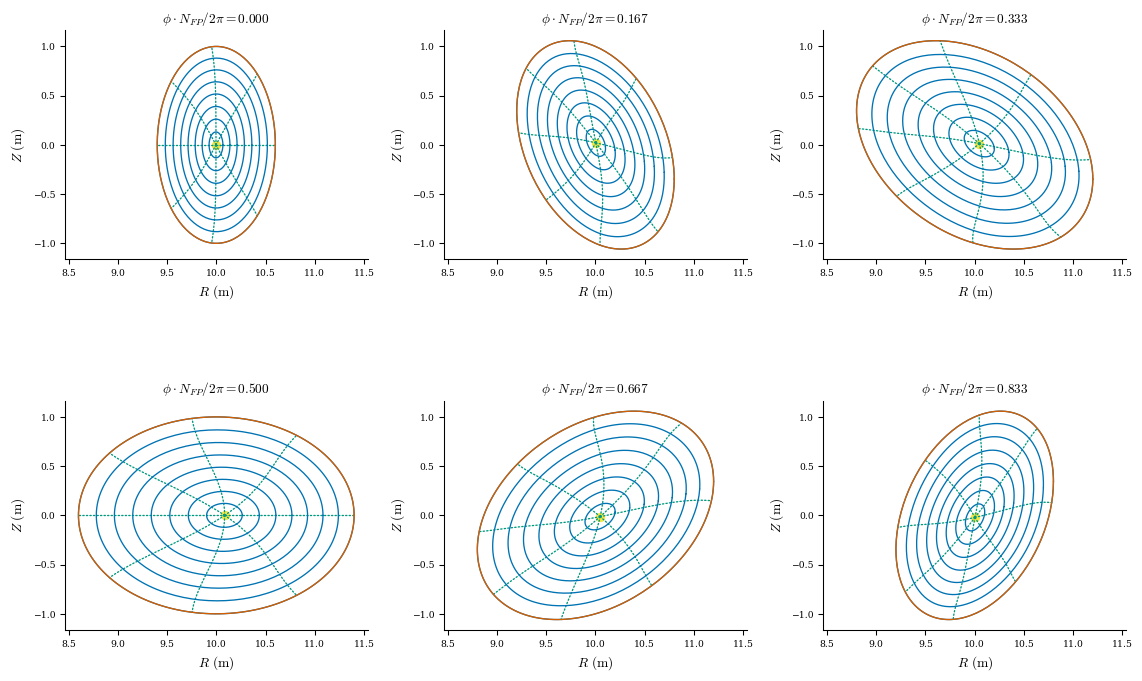

In [26]:
plot_surfaces(eq2);

Again, note that the force error increases after the perturbation. How much it increases depends on the "size" of the perturbation (note that due to the highly nonlinear equations, the "size" of the perturbation required to maintain force balance depends on the starting equilibrium as well as the actual delta).

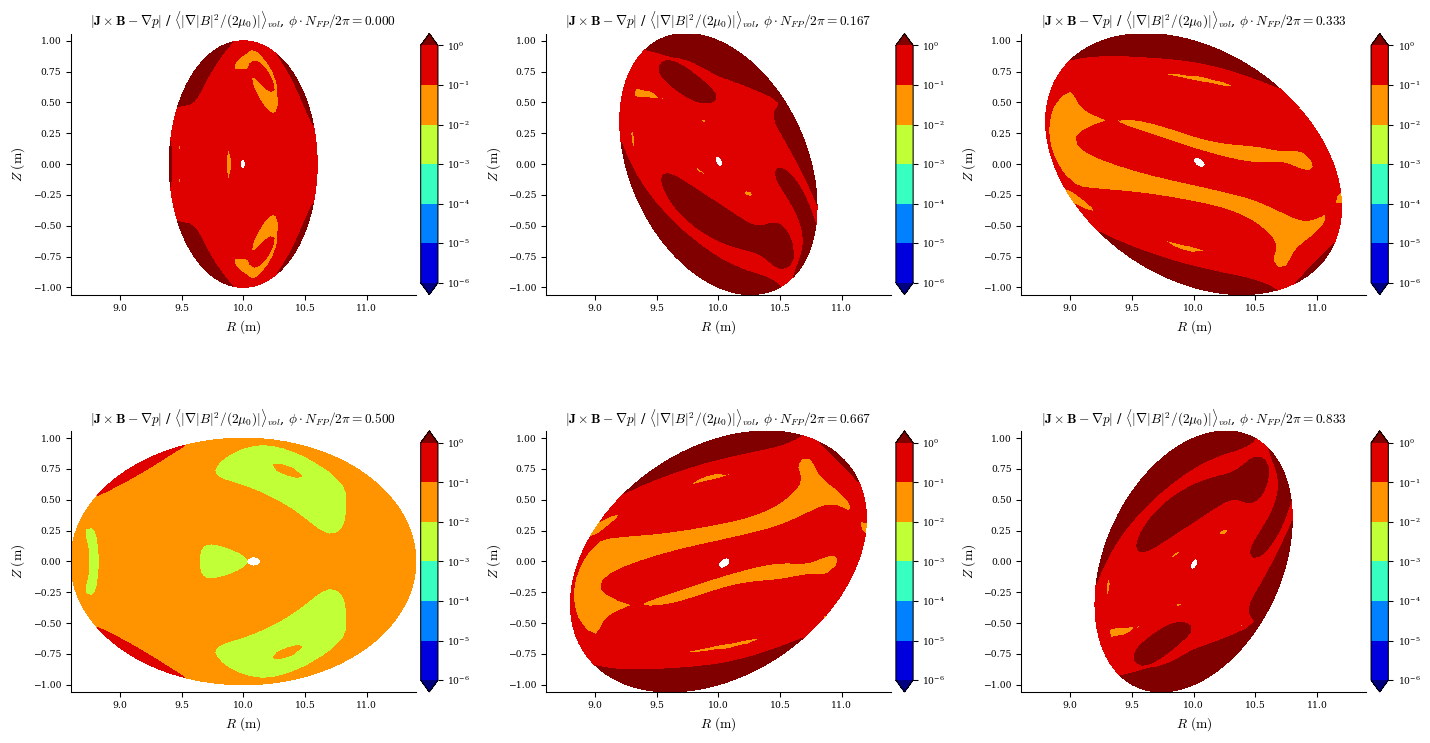

In [27]:
plot_section(eq2, "|F|", norm_F=True, log=True);

We can again run a few additional Newton iterations to improve the force balance error.

In [28]:
eq2.solve(
    verbose=2, ftol=1e-2, optimizer=optimizer, objective=obj, constraints=constraints
);

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 229 ms
Timer: Objective build = 433 ms
Timer: Linear constraint projection build = 3.27 sec
Compiling objective function and derivatives: ['force']
Timer: Objective compilation time = 1.96 sec
Timer: Jacobian compilation time = 5.36 sec
Timer: Total compilation time = 7.33 sec
Number of parameters: 193
Number of objectives: 882
Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          1.657e-02                                    2.669e+00   
       1              2          1.042e-04      1.647e-02      5.421e-01      1.301e-01   
       2              3          2.940e-05      7.476e-05      3.342e-01      5.728e-02   
       3              4          1.946e-06      2.746e-05      1.768e-01      1.319e-02   
       4              5          1.366e-06      5.794e-07      7.336e-02      1.843e-0

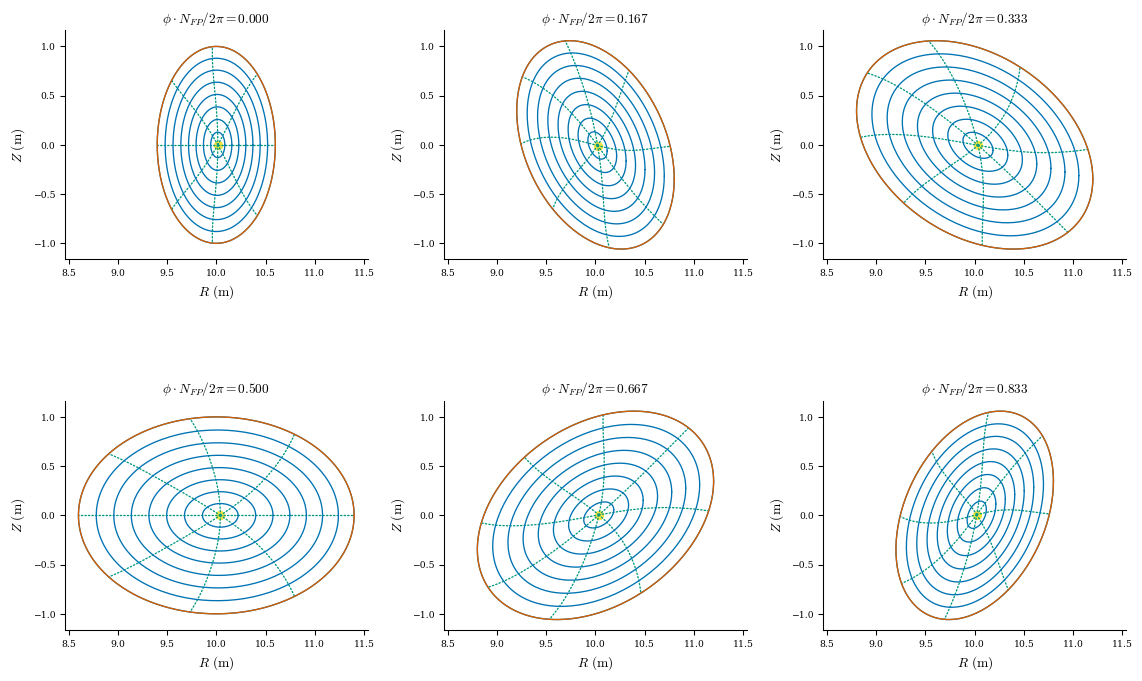

In [29]:
plot_surfaces(eq2);

Note again how the flux surfaces remain very similar, as the perturbation captures them accurately. Additional Newton iterations primarily serve to reduce the force error

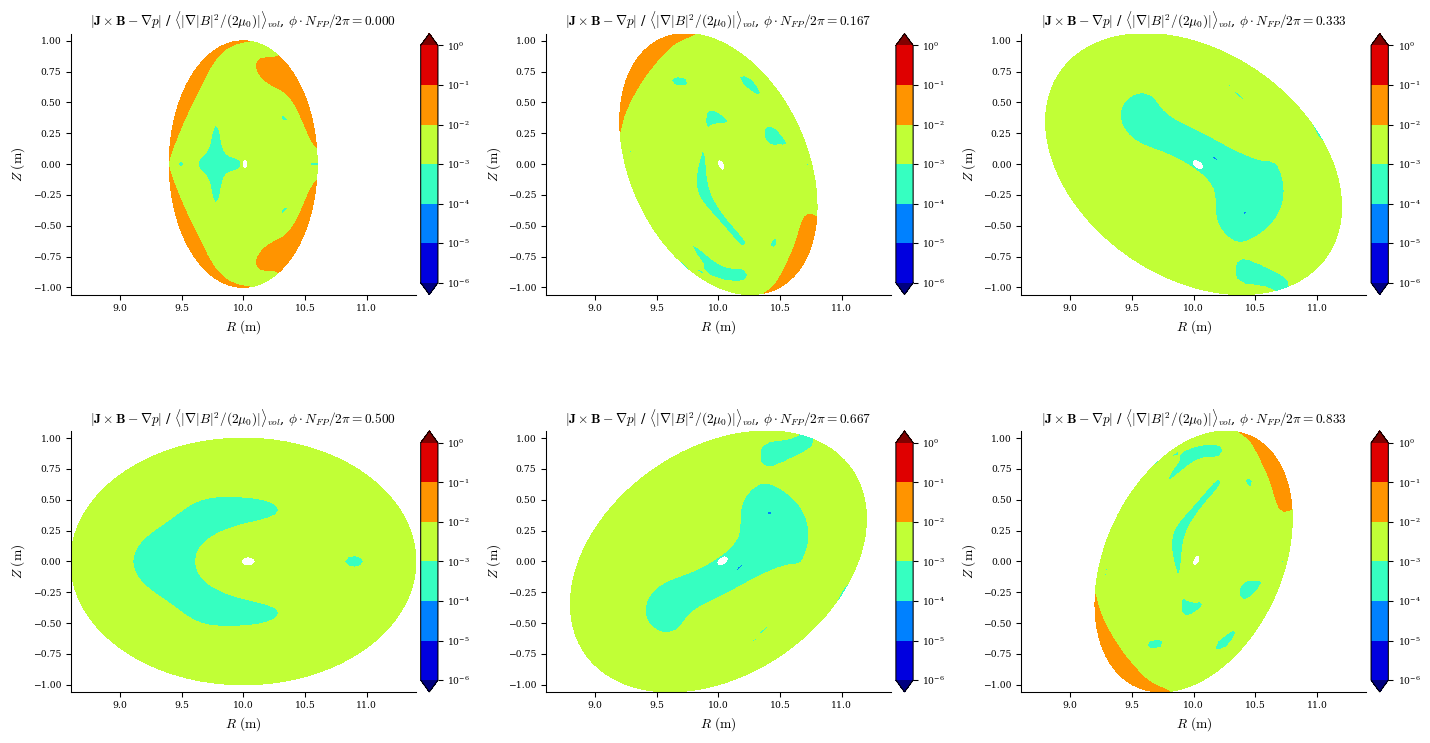

In [30]:
plot_section(eq2, "|F|", norm_F=True, log=True);

Note that even after additional Newton iterations, the force error is still rather high (between 1% and 10% throughout most of the volume). This is because the resolution we used was rather low, meant to be a quick demonstration rather than a realistic high quality solution. As DESC uses a pseudo-spectral discretization, increasing the resolution should decrease the error roughly exponentially.